# Package Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import mysql.connector
import os
import seaborn as sns

# Data Cleaning

First we downloaded the excel file from the UCI ML repo.  The sheets were then downloaded as csv and split by sheet (one for 2009-2010, the other for 2010-2011)

Next we read in these csv files to pandas dataframes, add a flag to show the original sheet, combine them, and begin data cleaning.  The flag is for checking if issues occured in reading in the csv or if they were present in the original data.  Can be removed after cleaning.

In [2]:
# load_dotenv()
# mysqluser = os.getenv("mysqluser")
# mysqlpassword = os.getenv("mysqlpassword")
# mysqlhost = os.getenv("mysqlhost")
# mysqldatabase = os.getenv("mysqldatabase")

# try:
#     cnx = mysql.connector.connect(user=mysqluser, password=mysqlpassword,
#                                 host=mysqlhost, database=mysqldatabase)
#     query = "SELECT * from onlineretail"
#     df = pd.read_sql(query, cnx)
#     cnx.close()
# except Exception as e:
#     cnx.close()
#     print(str(e))

In [3]:
df1 = pd.read_csv(r"data/online_retail_II_2009_2010.csv", encoding='unicode_escape', parse_dates=['InvoiceDate'])
df1['Flag'] = 1
df2 = pd.read_csv(r"data/online_retail_II_2010_2011.csv", encoding='unicode_escape', parse_dates=['InvoiceDate'])
df2['Flag'] = 2
df = pd.concat([df1, df2])
df.reset_index(inplace=True, drop=True)
# df.head()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   Flag         1067371 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 73.3+ MB


Invoice must remain as str because of ones such as 'C489449'.  
Similarly, stockcode must remain as str.  
customerid is converted to Int64 which allows for the NaN values (int alone doesn't)

In [5]:
df.columns = df.columns.str.strip().str.lower()  # Strip leading/trailing whitespace and lowercase all column names
df.rename(columns={"customer id":"customerid"}, inplace=True)  # remove whitespace in customer ID as well
df.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customerid', 'country', 'flag'],
      dtype='object')

In [6]:
df['customerid'] = df['customerid'].astype('Int64')

In [7]:
df.isnull().sum()

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customerid     243007
country             0
flag                0
dtype: int64

<AxesSubplot:>

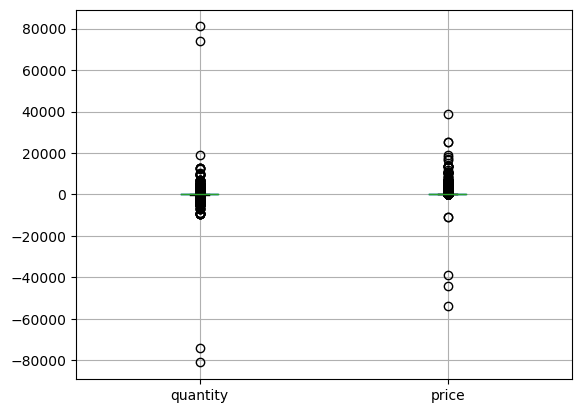

In [8]:
df.boxplot(column=['quantity', 'price'])

In [9]:
print(f"{len(df[df.quantity < 0]) / len(df) * 100:.2f}% of our quantities are negative") 
print(f"{len(df[df.price < 0]) / len(df) * 100:.2f}% of our prices are negative") 
print(f"{len(df[df.price == 0]) / len(df) * 100:.2f}% of our prices are equal to zero") 

2.15% of our quantities are negative
0.00% of our prices are negative
0.58% of our prices are equal to zero


Data has invoices prefaced with 'c' indicating that the order was cancelled.  Many of these are the places where the quantities are negative indicating a return.

In [10]:
canceldf = df[df.invoice.str.startswith('C')]  # store cancelled items

In [11]:
df = df[df.quantity > 0]  # Get rid of zero or negative quantity orders
df = df[df.price > 0]  # Get rid of zero or negative price orders

In [12]:
# Add revenue column for future analysis
df['revenue'] = df.quantity * df.price

In [13]:
def hasnumbers(inputstr):
    return any(char.isdigit() for char in inputstr)

nonum = df[df.stockcode.apply(hasnumbers) == False]  # See where the df has a stockcode that contains no numbers
nonum.stockcode.unique()

array(['POST', 'DOT', 'M', 'BANK CHARGES', 'PADS', 'ADJUST', 'm', 'D',
       'S', 'DCGSSBOY', 'DCGSSGIRL', 'AMAZONFEE', 'B'], dtype=object)

Where the stockcode has no numbers, the charges are for things that are not actually sales of items.  As such we will make these a separate df 'nonum' and continue with our analysis using the 'actual' sales data.

In [14]:
df = df[df.stockcode.apply(hasnumbers) == True]

There exist 'test' items in our data as well, remove those.

In [15]:
df = df[~df.stockcode.str.contains('TEST')]

In [16]:
print(df.revenue.quantile([0, 0.25, 0.5, 0.75, 1]))
print(f"Only {len(df[df.revenue >= 5000])/len(df)*100}% of the df has revenue over 5000")
df[df.revenue >= 5000]

0.00         0.06
0.25         3.90
0.50         9.96
0.75        17.70
1.00    168469.60
Name: revenue, dtype: float64
Only 0.0009640301085883514% of the df has revenue over 5000


,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag,revenue
228042,511465,15044A,PINK PAPER PARASOL,3500,2010-06-08 12:59:00,2.55,18008,United Kingdom,1,8925.00
379875,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3120,2010-10-08 10:10:00,1.66,15838,United Kingdom,1,5179.20
432176,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838,United Kingdom,1,15818.40
461644,533027,22086,PAPER CHAIN KIT 50'S CHRISTMAS,835,2010-11-15 16:02:00,6.95,<NA>,United Kingdom,1,5803.25
578172,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749,United Kingdom,2,6539.40
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2,77183.60
686007,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,United Kingdom,2,6539.40
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,2,38970.00
873786,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450,United Kingdom,2,7144.72
1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,2,168469.60


We can see that only a tiny amount of our data exists at or over this threshold of >= 5,000 sterling in revenue.  These may be real sales but their extreme values lead that to be suspect.  Even going down to a threshold of 2,500 sterling there are only 100 rows.  In any case, these over 5,000 seem so extreme compared to the rest of our data that we will exclude them from analysis.  Some very possible errors will remain for our sales where the revenue is extremely high but under 5,000 but we lack the data understanding to remove even more at this time.

In [17]:
df = df[df.revenue < 5000]

In [18]:
print(df.revenue.quantile([0, 0.25, 0.5, 0.75, 1]))


0.00       0.06
0.25       3.90
0.50       9.96
0.75      17.70
1.00    4992.00
Name: revenue, dtype: float64


In [20]:
df.to_csv(r"data/cleanOnlineRetail.csv")

# Business Questions

1. What are our most commonly ordered items?
2. What is our total revenue?
3. When did we sell the most?
4. How do our sales trends look over time / by country?
5. Where do we sell the most?
6. Where is most profitable to sell?
7. What are our most profitable items?  Where are they sold the most?
8. How does our customer retention look?
9. What items are frequently bought together?

    9.1. What are our most common combinations of items?

    9.2. '85099B' is our most sold item by quantity, what is it often sold with?
    
    9.3. Our highest revenue generating item is '85123A', what is it often sold with?

## 1: What are our most commonly ordered items?
Our most commonly ordered item is 85123A which is a white/cream colored T-light holder.

To be clear, this is speaking about the number of times an item is ordered rather than the number of the item within the order.  If item 'ABC123' was bought in two orders but at a quantity of 5,000 each time it would be lower than item 'DCF456' which was sold in three orders and a quantity of 1 per order.  Looking at the total quantity of items sold will be in business question 7.

In [21]:
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,1,30.0


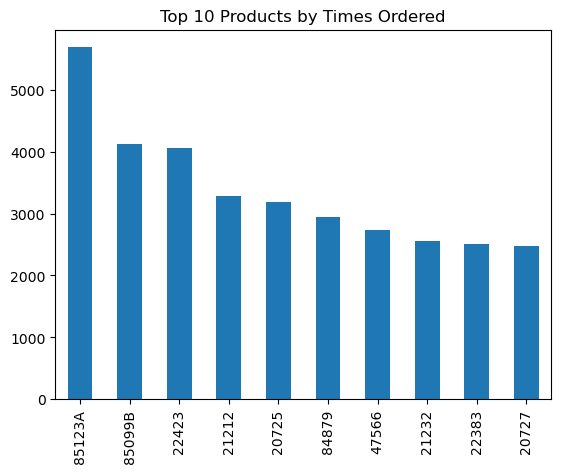

In [22]:
df.stockcode.value_counts()[:10].plot(kind='bar', title='Top 10 Products by Times Ordered');
plt.show()

In [23]:
df[df.stockcode=='85123A'].description.unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

## 2: What is our total revenue?
Our total revenue is 20,972,968.14 pound sterling.

In [24]:
print(f"Our total revenue is {df.revenue.sum():.2f} pound sterling")

Our total revenue is 19785224.67 pound sterling


## 3: When did we sell the most?
Near the starts and ends of the year.

We can see that in terms of number of sales, we peak at around the start/end of the year.  In terms of revenue, we can see our peaks are mostly around the end of the year in October or November.

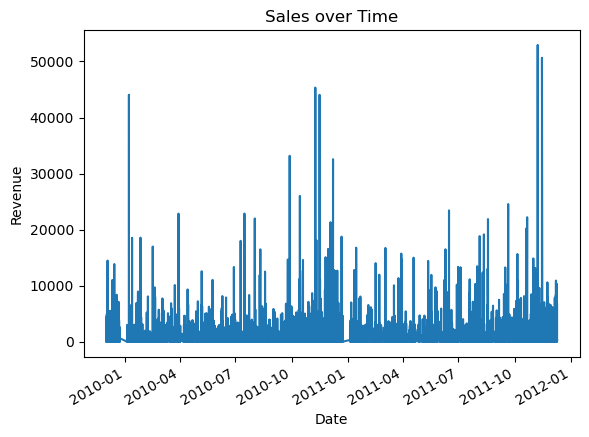

In [25]:
ax = df.groupby("invoicedate").sum().revenue.plot()
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Sales over Time")
plt.show()
fig = ax.get_figure()
fig.savefig(r"data/imgs/salesOverTime.png")

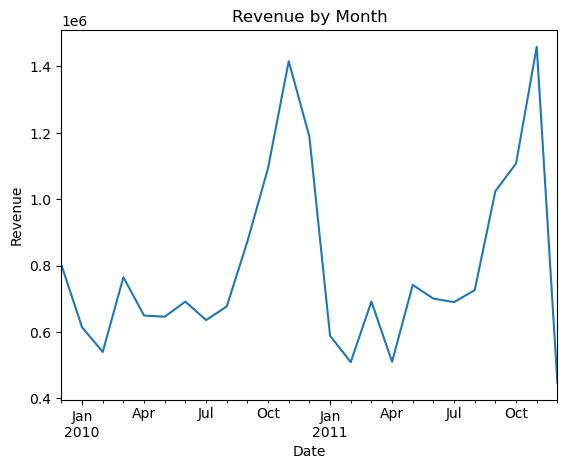

In [26]:
ax = df.resample(rule='M', on='invoicedate')['revenue'].sum().plot();
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue by Month")
plt.show();
fig = ax.get_figure()
fig.savefig(r"data/imgs/revByMonth.png")


## 4: Sales trends over time and by country

See plots below

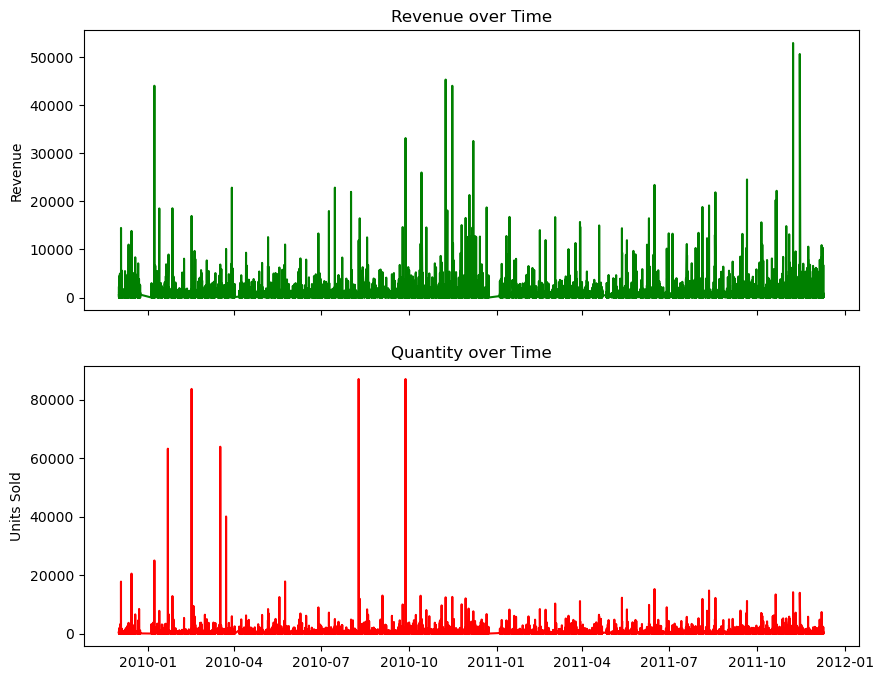

In [27]:
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)
# df.groupby("invoicedate").sum().revenue.plot(ax=axes[0])
# df.groupby("invoicedate").sum().quantity.plot(ax=axes[1])
axs[0].plot(df.groupby("invoicedate").sum().revenue, c='green');
axs[0].set_title("Revenue over Time")
axs[0].set_ylabel("Revenue")
axs[1].plot(df.groupby("invoicedate").sum().quantity, c='red');
axs[1].set_title('Quantity over Time')
axs[1].set_ylabel("Units Sold")
plt.show();

The above plots show that spikes in quantity sold do not directly translate to spikes in revenue.  

There are a lot of results possible looking by country since we sell to such a wide market.  As such we will look only at the top 6 countries for plotting, but this can be changed for future analysis if it is called for.

In [28]:
top6Countries = df.groupby(["country"]).sum().revenue.nlargest(6).keys()  # Get top 5 countries' names, sorted by sum of revenues.
top6Countries

Index(['United Kingdom', 'EIRE', 'Netherlands', 'Germany', 'France',
       'Australia'],
      dtype='object', name='country')

In [29]:
def showCountrySales(countries, n=2, setShareY=False):
    """
    Small function to plot country revenue over time
    
    args:
        countries (list): List of contries to plot revenue over time for
        n (int): Skip every n'th xlabel for cleaner graphs.  Default skips every other one.
        setShareY (bool): Set if you want the y axes to be shared.  Off by default due to UK dominating in our example
    """
    fig, axs = plt.subplots((len(countries))//3, 3, figsize=(20,5), sharex=True, sharey=setShareY)
    grouped = df.groupby(["country","invoicedate"]).sum().revenue
    for country, ax in zip(countries, fig.axes):
        ax.plot(grouped[country]);
        plt.setp(ax.get_xticklabels()[::n], visible=False)
        ax.set_xlabel(country)
    fig = ax.get_figure()
    fig.savefig(r"data/imgs/salesByCountry.png")
    plt.show()

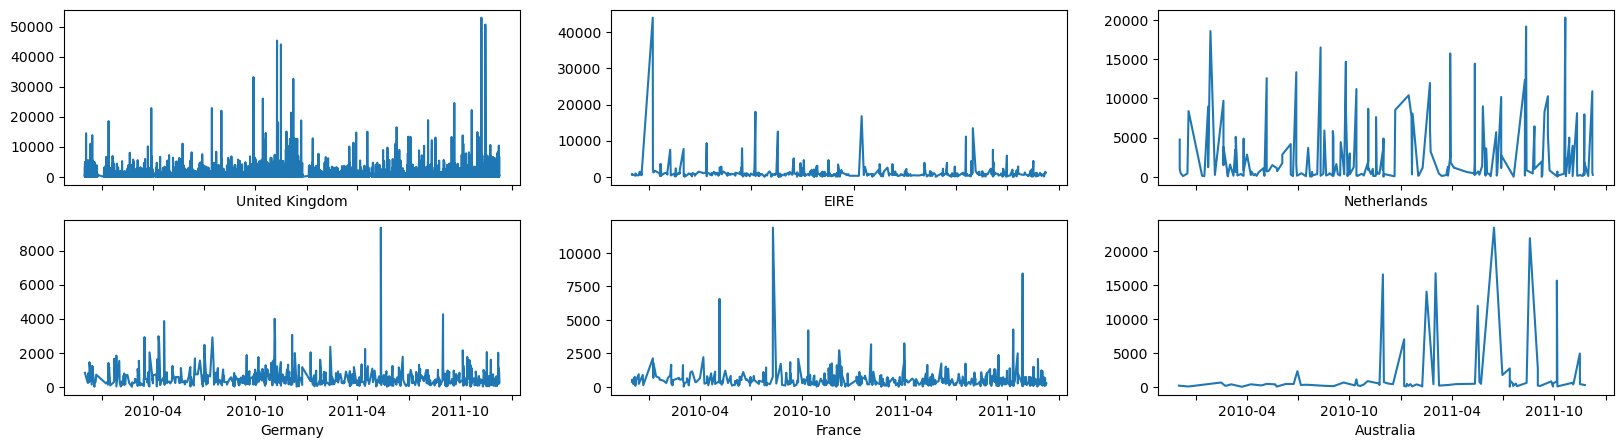

In [30]:
showCountrySales(top6Countries)

## 5: Where do we sell the most?
The UK by far.

In terms of both revenue generated and quantity sold, the UK dominates.  After that, we generate the most revenue in Ireland but sell more quantity in the Netherlands.

In [31]:
n=6
topNRevenue = df.groupby(["country"]).sum().revenue.nlargest(n)
topNQuantity = df.groupby(["country"]).sum().quantity.nlargest(n)
print(f"Our top {n} countries by revenue are: {topNRevenue.keys().values} selling {topNRevenue.values} streling respectively")
print(f"Our top {n} countries by quantity sold are {topNQuantity.keys().values} selling {topNQuantity.values} units respectively")

Our top 6 countries by revenue are: ['United Kingdom' 'EIRE' 'Netherlands' 'Germany' 'France' 'Australia'] selling [16898193.96   638933.63   549952.66   388829.75   317344.8    168484.66] streling respectively
Our top 6 countries by quantity sold are ['United Kingdom' 'Netherlands' 'EIRE' 'France' 'Denmark' 'Germany'] selling [9191468  383722  340247  273938  237852  225878] units respectively


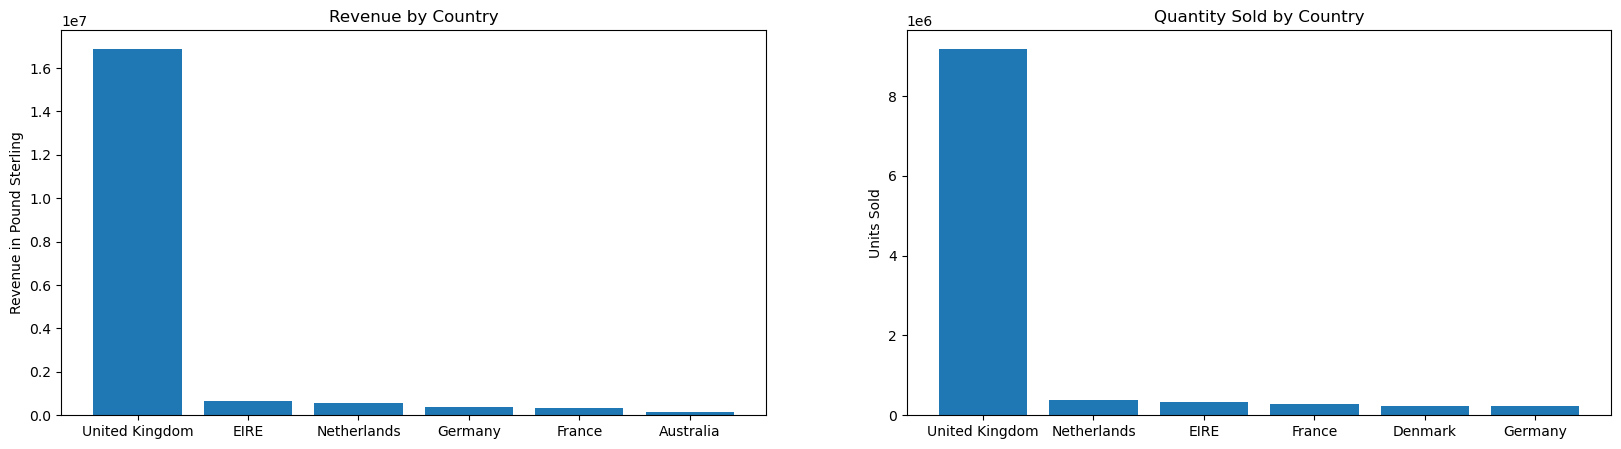

In [32]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].bar(topNRevenue.keys(), topNRevenue.values);
axes[0].set_title("Revenue by Country")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[1].bar(topNQuantity.keys(), topNQuantity.values);
axes[1].set_title("Quantity Sold by Country")
axes[1].set_ylabel("Units Sold")
fig.savefig(r"data/imgs/revAndQuantByCountry.png")
plt.show()

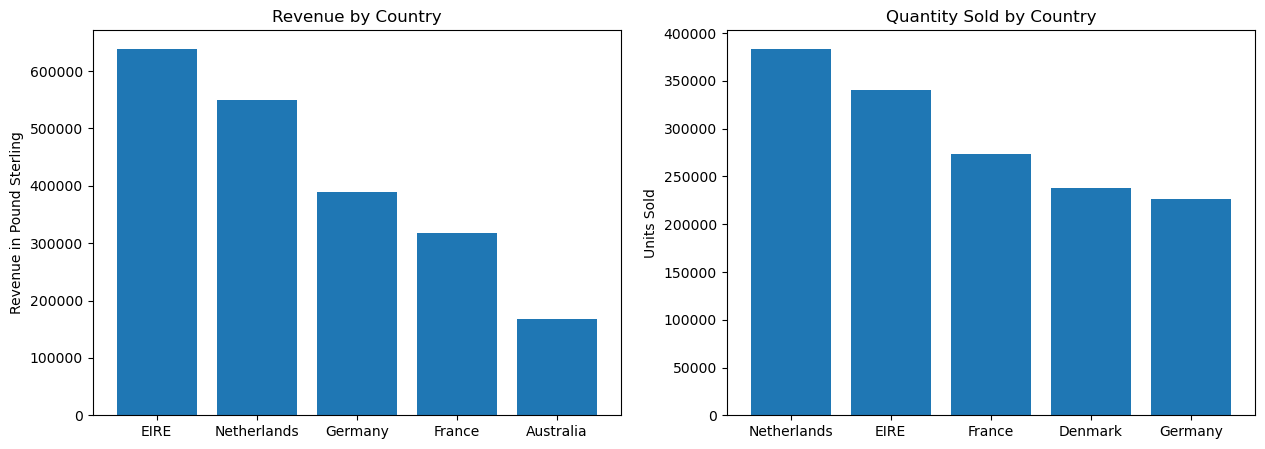

In [33]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(topNRevenue.keys()[1:], topNRevenue.values[1:]);
axes[0].set_title("Revenue by Country")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[1].bar(topNQuantity.keys()[1:], topNQuantity.values[1:]);
axes[1].set_title("Quantity Sold by Country")
axes[1].set_ylabel("Units Sold")
fig.savefig(r"data/imgs/revAndQuantByCountryNOUK.png")
plt.show()

## 6: Where is most profitable to sell?
The UK dominates, followed by Ireland and perhaps the Netherlands

This ties in to our previous question. It is clear from question 5 that focusing on the UK is our bread and butter.  Past this though, Ireland and the Netherlands are our best bets.  Ireland seems to buy higher priced items at a slightly lower quantity than the Netherlands, but the Netherlands likes to buy al arger quantity of lower priced goods.  As such we could continue as we are within the UK but seek to expand within Ireland or the Netherlands.  Ireland makes the most sense due to proximity with our UK market and already largue revenue generation.  The slightly lower quantity sold means less than the higher revenue.  

## 7: What are our most profitable items?  Where are they sold the most?
'85123A' is our best item by revenue generated and it is sold the most in the UK, followed distantly by Ireland.

This ties together questions 1 and 5.

In [34]:
n=15
topNItemRev = df.groupby(["stockcode"]).sum().revenue.nlargest(n)
topNItemQuant = df.groupby(["stockcode"]).sum().quantity.nlargest(n)
# print(f"Our top {n} items by revenue are: {topNItemRev.keys().values}\n" 
#       f"selling {topNItemRev.values} streling respectively"
#       f"Our top {n} items by quantity sold are {topNItemQuant.keys().values}\n"
#       f"selling {topNItemQuant.values} units respectively")

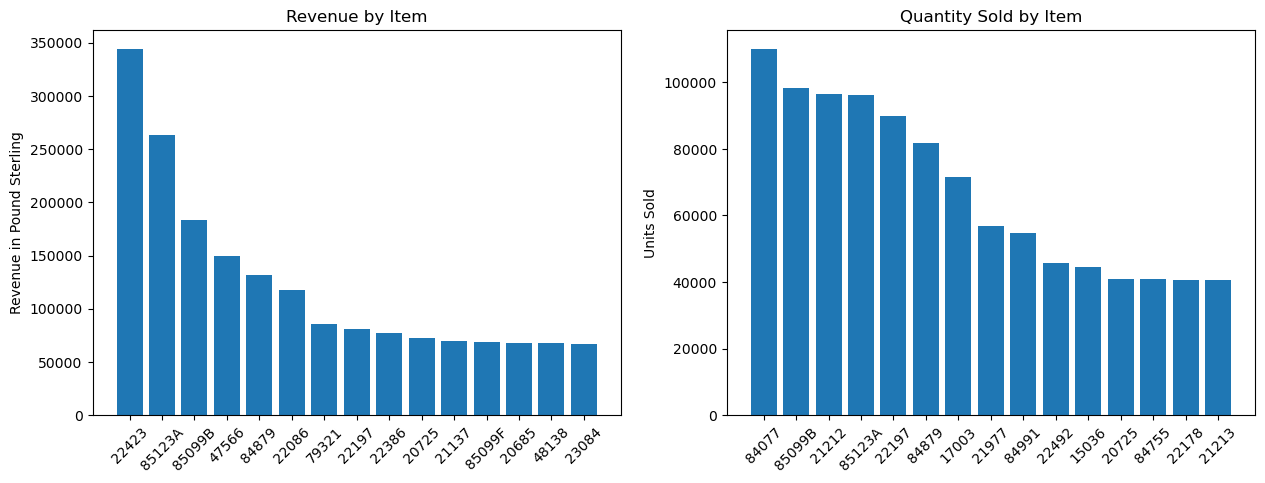

In [35]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(topNItemRev.keys(), topNItemRev.values);
axes[0].set_title("Revenue by Item")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[0].tick_params('x', labelrotation=45);
axes[1].bar(topNItemQuant.keys(), topNItemQuant.values);
axes[1].set_title("Quantity Sold by Item")
axes[1].set_ylabel("Units Sold")
axes[1].tick_params('x', labelrotation=45);
fig.savefig(r"data/imgs/revQuantByItem.png")
plt.show();

In [36]:
df[df.stockcode == '22423'].description.unique()

array(['REGENCY CAKESTAND 3 TIER'], dtype=object)

In [37]:
df[df.stockcode == '84077'].description.unique()

array(['WORLD WAR 2 GLIDERS ASSTD DESIGNS'], dtype=object)

Our largest revenue generator is '22423' which is a cakestand, and our most commonly sold item is '84077' which are WWII glider designs.  

Lets try to find our common items between top revenue generators and most sold items by quantity.  

In [38]:
def findMatches(n=15):
    """
    Finds items which are both in the top 'n' for revenue and quantity sold

    Args:
        n (int): The number of top 'n' items to look through. Defaults to 15.
    """
    topNItemRevCodes = set(df.groupby(["stockcode"]).sum().revenue.nlargest(n).keys())
    topNItemQuantCodes = set(df.groupby(["stockcode"]).sum().quantity.nlargest(n).keys())
    if (topNItemRevCodes & topNItemQuantCodes):
        return(topNItemRevCodes & topNItemQuantCodes)
    else:
        print("No Common Stock Codes")

In [39]:
for stockCode in list(findMatches(n=15)):
    print(f"For item {stockCode}, {df.groupby(['stockcode']).sum().quantity[stockCode]} items were sold for a total of {df.groupby(['stockcode']).sum().revenue[stockCode]:.2f} pound Sterling")

For item 22197, 89898 items were sold for a total of 80920.64 pound Sterling
For item 85099B, 98349 items were sold for a total of 183454.83 pound Sterling
For item 20725, 40942 items were sold for a total of 72292.85 pound Sterling
For item 84879, 81809 items were sold for a total of 132187.92 pound Sterling
For item 85123A, 96147 items were sold for a total of 263109.67 pound Sterling


In [40]:
matchRev = df.groupby(["stockcode"]).sum().revenue[list(findMatches(n=15))].sort_values(ascending=False)
matchQuant = df.groupby(["stockcode"]).sum().quantity[list(findMatches(n=15))]

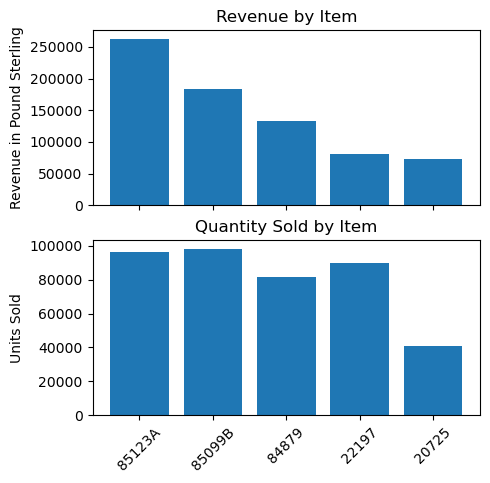

In [41]:
fig, axes = plt.subplots(2,1, figsize=(5,5), sharex=True)
axes[0].bar(matchRev.keys(), matchRev.values);
axes[0].set_title("Revenue by Item")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[0].tick_params('x', labelrotation=45);
axes[1].bar(matchQuant.keys(), matchQuant.values);
axes[1].set_title("Quantity Sold by Item")
axes[1].set_ylabel("Units Sold")
axes[1].tick_params('x', labelrotation=45);
fig.savefig(r"data/imgs/topItemRevQuant.png")
plt.show();

While we see a similar amount of '85123A' being sold as '85099B', the revenue for the former is much higher than for the latter.  From this we can see that focusing on '85123A' (our white/cream colored holder) is our best bet.  With that said, people clearly buy quite a few of our '85099B' (a jumbo spotted bag) so perhaps bundling this with other items would generate larger revenue.

Overall it is hard to analyze the true profitability of our items as we have no data on the COGS.  If we had this, we could create a 'profit' column in the dataframe and do further analysis.  For now though, looking purely at the revenue, we should focus on '85123A' and perhaps bundle '85099B' with other items that we wish to promote. 

In [42]:
df[df.stockcode == '85123A'].country.value_counts()[:10]

United Kingdom     5477
EIRE                 87
Netherlands          28
Spain                20
Cyprus               14
Switzerland           9
Italy                 7
Channel Islands       7
France                7
Germany               6
Name: country, dtype: int64

We sell the most of our best item in the UK, followed by Ireland.

## 8: Customer Retention
Existing customers are looking good, but we should incentivize new customers.

In [43]:
earliestdf = df.groupby('customerid').invoicedate.min().reset_index()
earliestdf.columns = ['customerid', 'earliestpurchasedate']
df2 = df.copy()
df2 = pd.merge(df2, earliestdf, on='customerid')
df2['custstatus'] = 'New'  # default each purchase to have the customer be 'new'
df2.loc[df2['invoicedate'] > df2['earliestpurchasedate'], 'custstatus'] = 'Existing'  # If the invoice is later than the earliest purchase, that is an order from an existing customer

revByStatus = df2.groupby(['invoicedate', 'custstatus'])['revenue'].sum().reset_index()  # New df to store grouped revenue by customer status
revNew = revByStatus[revByStatus.custstatus=='New'].resample(rule='M', on='invoicedate')['revenue'].sum().reset_index()  # Group by month and sum revenue within each month for new custs
revExisting = revByStatus[revByStatus.custstatus=='Existing'].resample(rule='M', on='invoicedate')['revenue'].sum().reset_index()  # as above but for existing custs

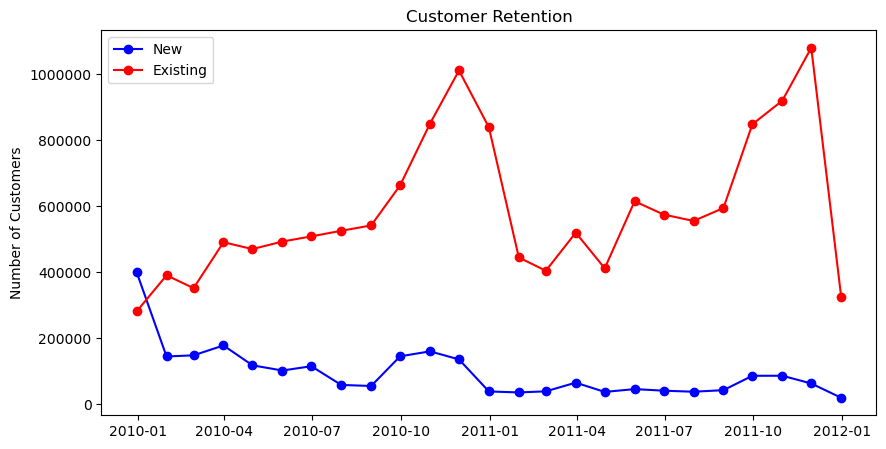

In [44]:
plt.figure(figsize=(10,5));
plt.plot(revNew.invoicedate, revNew.revenue, '-o', c='b', label='New');
plt.plot(revExisting.invoicedate, revExisting.revenue, '-o', c='r', label='Existing');
plt.title("Customer Retention");
plt.legend();
plt.ticklabel_format(style='plain', axis='y');
plt.ylabel("Number of Customers")
plt.show()

We can see that our number of existing customers seems to be on an okay - slightly positive - slope, but we see a slightly negative slope to our new customers over time.  This indicates that we are doing an okay job with our existing methods of customer retention, but we should perhaps put new efforts into our marketing for new customers.

## 9: Items Frequently Bought Together
We create a dataframe using the Apriori algorithm and a minimum support of 0.005 (must be small as we have a very sparse dataset) and use this to answer three hypothetical questions about our frequently combined items.

In [45]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [46]:
# Get all transactions with their relevant items
d = {}
for idx, row in df.iterrows():
    if row['invoice'] not in d:
        d[row['invoice']] = [row['stockcode']]
    else:
        d[row['invoice']].append(row['stockcode'])

In [47]:
# Turn the transactions dictionary into an apriori-friendly dataframe
ser = pd.Series({k: list(v) for k, v in d.items()}).str.join('|').str.get_dummies()
ser = ser.astype(bool)  # 0's and 1's may be depreciated in apriori soon, use bool instead

In [48]:
ser.head()

,10002,10002R,10080,10109,10120,10123C,10123G,10124A,10124G,10125,...,DCGS0075,DCGS0076,SP1002,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,gift_0001_70,gift_0001_80
489434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489436,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489437,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489438,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
smallItems = apriori(ser, min_support=0.005, use_colnames=True, low_memory=True)
smallItems['length'] = smallItems['itemsets'].apply(lambda x: len(x))

smallItems now can be searched for what we want to find out.  For example, we could look for the most probable combinations with this minimum support, the largest combinations, look for specific items and see what it's often bought together with, etc.  Let's come up with some example questions and answer them.

### 9.1: What are our most common combinations of items?

In [67]:
smallItems[smallItems.length > 1].sort_values(by='support', ascending=False)[:10]

,support,itemsets,length
4723,0.036080,"(22386, 85099B)",2
3747,0.033499,"(85099B, 21931)",2
3380,0.031222,"(85123A, 21733)",2
1947,0.030413,"(20725, 20727)",2
2913,0.030286,"(84991, 21212)",2
5621,0.029957,"(85099B, 85099F)",2
2030,0.029780,"(20725, 22383)",2
4750,0.029274,"(22411, 85099B)",2
2031,0.029249,"(22384, 20725)",2
2790,0.028110,"(21977, 21212)",2


We can see our most commonly sold together items (with a min support of 0.005) above.  '85099B' is our most commonly sold item by quantity so it makes sense to see it included here multiple times.  If we look back at our revenue/quantity by item graph we can see many of these items expressed here.  As a reminder, our top 5 items by revenue were '85123A', '85099B', '84879', '22197', and '20725'.  

### 9.2: '85099B' is our most sold item by quantity, what is it often sold with?

In [79]:
smallItems[smallItems['itemsets'] > {'85099B'}].sort_values(by='support', ascending=False)[:10]

,support,itemsets,length
4723,0.036080,"(22386, 85099B)",2
3747,0.033499,"(85099B, 21931)",2
5621,0.029957,"(85099B, 85099F)",2
4750,0.029274,"(22411, 85099B)",2
5620,0.027984,"(85099B, 85099C)",2
2098,0.027807,"(20725, 85099B)",2
3622,0.023202,"(21928, 85099B)",2
3653,0.022999,"(21929, 85099B)",2
5622,0.021987,"(85123A, 85099B)",2
1612,0.021557,"(20712, 85099B)",2


We can see that our highest revenue generator is often sold together with items that weren't actually in our top 5 revenue generators such as '22386' and '21931' which were most common.  Perhaps we could bundle these items together with a third high revenue generator for promotional purposes.

In [113]:
# Get every unique item from our smallItem query in 9.2 above.
setlist = [(x,y) for x, y in smallItems[smallItems['itemsets'] > {'85099B'}].sort_values(by='support', ascending=False)[:10].itemsets]
bucket = []
for s in setlist:
    for e in s:
        if e in bucket:
            continue
        else:
            bucket.append(e)

In [124]:
# For every item above, get every description that that stockcode has had (note some have had 2 descriptions of the same item)
df[df.stockcode.isin(bucket)][['stockcode', 'description']].groupby('stockcode').description.unique().reset_index()

,stockcode,description
0,20712,[JUMBO BAG WOODLAND ANIMALS]
1,20725,"[LUNCH BAG RED SPOTTY, LUNCH BAG RED RETROSPOT]"
2,21928,"[JUMBO BAG SCANDINAVIAN PAISLEY, JUMBO BAG SCA..."
3,21929,[JUMBO BAG PINK VINTAGE PAISLEY]
4,21931,[JUMBO STORAGE BAG SUKI]
5,22386,"[JUMBO BAG PINK WITH WHITE SPOTS, JUMBO BAG PI..."
6,22411,[JUMBO SHOPPER VINTAGE RED PAISLEY]
7,85099B,"[JUMBO BAG RED WHITE SPOTTY , RED RETROSPOT JU..."
8,85099C,[JUMBO BAG BAROQUE BLACK WHITE]
9,85099F,[JUMBO BAG STRAWBERRY]


Since '22386' is often sold with our bestseller of '85099B' we may want to bundle them together.  Both of these are similarly colored, spotted bags.  ACtually if we look, many of these are similarly spotted bags which are often sold together.  This shows us that perhaps having a promotion of buy x get y free for bags might be successful.  Or some sort of mix-and-match of bags to promote people buying more.

### 9.3: Our highest revenue generating item is '85123A', what is it often sold with?

In [126]:
smallItems[smallItems['itemsets'] > {'85123A'}].sort_values(by='support', ascending=False)[:10]

,support,itemsets,length
3380,0.031222,"(85123A, 21733)",2
5622,0.021987,"(85123A, 85099B)",2
5462,0.020292,"(85123A, 82494L)",2
5443,0.020115,"(85123A, 82482)",2
4901,0.018976,"(22469, 85123A)",2
5558,0.018926,"(85123A, 84879)",2
4914,0.018900,"(85123A, 22470)",2
3107,0.018850,"(85123A, 21232)",2
2101,0.018749,"(85123A, 20725)",2
3413,0.018749,"(85123A, 21754)",2


In [127]:
# Get every unique item from our smallItem query in 9.3 above.
setlist = [(x,y) for x, y in smallItems[smallItems['itemsets'] > {'85123A'}].sort_values(by='support', ascending=False)[:10].itemsets]
bucket = []
for s in setlist:
    for e in s:
        if e in bucket:
            continue
        else:
            bucket.append(e)

In [128]:
# For every item above, get every description that that stockcode has had (note some have had 2 descriptions of the same item)
df[df.stockcode.isin(bucket)][['stockcode', 'description']].groupby('stockcode').description.unique().reset_index()

,stockcode,description
0,20725,"[LUNCH BAG RED SPOTTY, LUNCH BAG RED RETROSPOT]"
1,21232,"[STRAWBERRY CERAMIC TRINKET BOX, STRAWBERRY CE..."
2,21733,[RED HANGING HEART T-LIGHT HOLDER]
3,21754,[HOME BUILDING BLOCK WORD]
4,22469,[HEART OF WICKER SMALL]
5,22470,[HEART OF WICKER LARGE]
6,82482,[WOODEN PICTURE FRAME WHITE FINISH]
7,82494L,[WOODEN FRAME ANTIQUE WHITE ]
8,84879,[ASSORTED COLOUR BIRD ORNAMENT]
9,85099B,"[JUMBO BAG RED WHITE SPOTTY , RED RETROSPOT JU..."


This '85123A' light holder is often sold with '21733', another light holder.  Similarly to question 9.2 above we could have buy x get y free deals for our light holders.

# Modeling and Forecasting
Since almost all of our sales are in the UK we will focus our modeling and forecasting on the UK specifically.  
1. Prophet
2. XGBoost
    1. TimeSeriesSplit
    2. HYPEROPT
3. Linear Regression

## Create Time Features
First we must create some new time features for analysis.

In [446]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [72]:
def makeTimeFeatures(df, datecol='invoicedate', useidx=False):
    df = df.copy()
    if useidx == False:
        df['dayofweek'] = df[datecol].dt.dayofweek
        df['month'] = df[datecol].dt.month
        df['quarter'] = df[datecol].dt.quarter
        df['year'] = df[datecol].dt.year
        df['dayofyear'] = df[datecol].dt.dayofyear
        df['dayofmonth'] = df[datecol].dt.day
        df['weekofyear'] = df[datecol].dt.weekofyear
        df['season'] = pd.cut(df[datecol].dt.month, [0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])  # Rough season cutoffs
    else:
        df['dayofweek'] = df.index.dayofweek
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.weekofyear
        df['season'] = pd.cut(df.index.month, [0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])  # Rough season cutoffs
    return df

In [153]:
hourlydf = df[df.country == 'United Kingdom'][['invoicedate', 'revenue']].resample(rule='H', on='invoicedate').sum().reset_index()
timedf = makeTimeFeatures(hourlydf)
timedf['dayofweek'] = [x.strftime('%A') for x in timedf.invoicedate]  # Replace the day numbers with day names.  Could change in function, but this is mostly for the plot
timedf.head()

C:\Users\Zade\AppData\Local\Temp\ipykernel_6784\2333629205.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df[datecol].dt.weekofyear


,invoicedate,revenue,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,season
0,2009-12-01 07:00:00,651.10,Tuesday,12,4,2009,335,1,49,Fall
1,2009-12-01 08:00:00,0.00,Tuesday,12,4,2009,335,1,49,Fall
2,2009-12-01 09:00:00,4597.93,Tuesday,12,4,2009,335,1,49,Fall
3,2009-12-01 10:00:00,4238.66,Tuesday,12,4,2009,335,1,49,Fall
4,2009-12-01 11:00:00,4598.41,Tuesday,12,4,2009,335,1,49,Fall


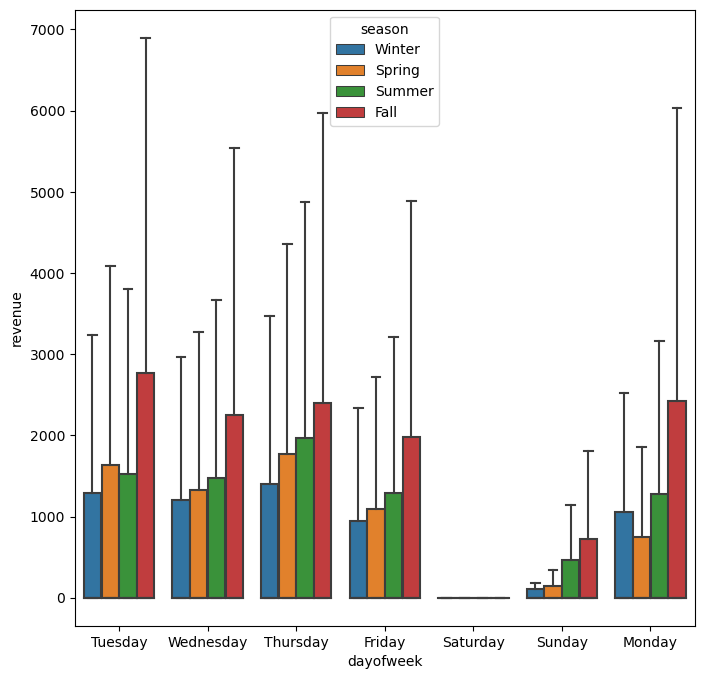

In [154]:
# Examine possible trends
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=timedf, x='dayofweek', y='revenue', hue='season', ax=ax, showfliers=False);  # If we don't exclude outliers the plots are useless.
plt.show();

Can see a dirth of sales on Saturday and majorly reduced sales on Sunday.  It also seems that there is some seasonality within our data as we can see peaks in the Fall.  This is expected from our previous analysis where we saw large spikes in revenue near the ends of the years.

## 1: Prophet Modeling
We get an RMSE of around 2362

Prophet helps to confirm that there is hardly any slope in our revenue indicating that we are on a plateau in our earnings.  We also see that the hour of the day is very important to the revenue generated.

In [155]:
from prophet import Prophet

In [188]:
cutoffdate = '2011-06-8'  # Get a roughly 75-25 split in our data
train = timedf.loc[timedf.invoicedate <= cutoffdate].copy()
test = timedf.loc[timedf.invoicedate > cutoffdate].copy()
print(f"{len(train)/len(timedf)*100:.2f}% of our data is in the training with this cutoff date")
trainProph = train.rename(columns={'invoicedate':'ds', 'revenue':'y'})
testProph = test.rename(columns={'invoicedate':'ds', 'revenue':'y'})

75.01% of our data is in the training with this cutoff date


In [189]:
model = Prophet()
model.fit(trainProph)
fcst = model.predict(testProph)

15:40:21 - cmdstanpy - INFO - Chain [1] start processing
15:40:25 - cmdstanpy - INFO - Chain [1] done processing


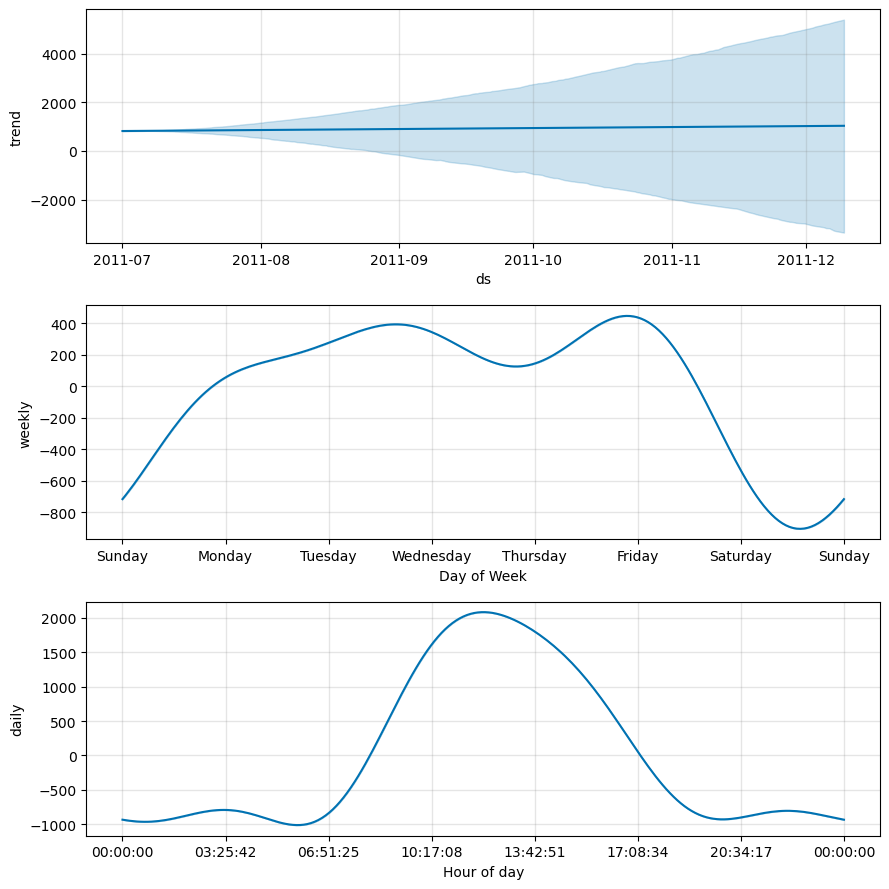

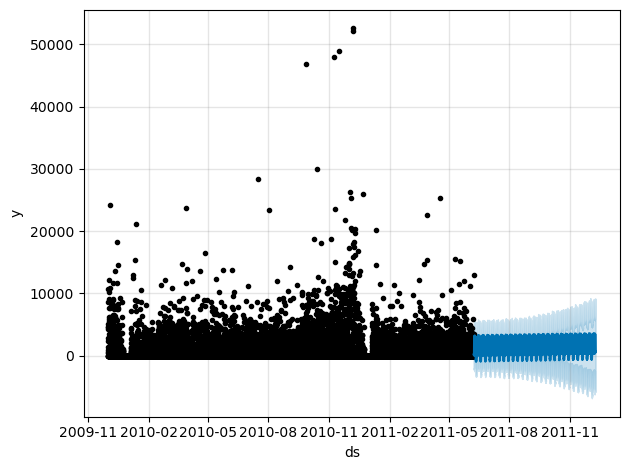

In [190]:
fig, ax = plt.subplots()
fig = model.plot(fcst, ax=ax);
plt.show();

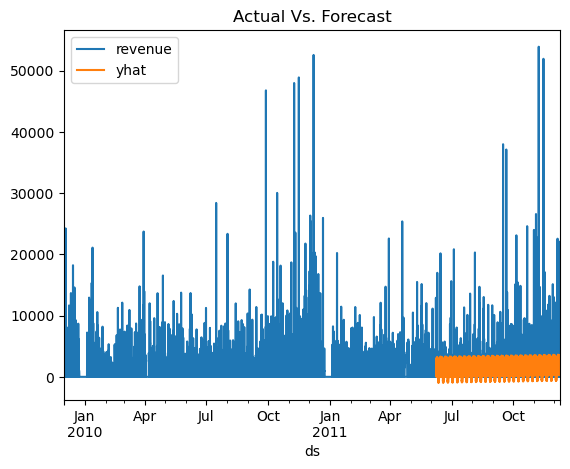

In [193]:
ax = (timedf.plot(x='invoicedate', y='revenue', title='Actual Vs. Forecast'));
fcst.plot(x='ds', y='yhat', ax=ax);
plt.show();

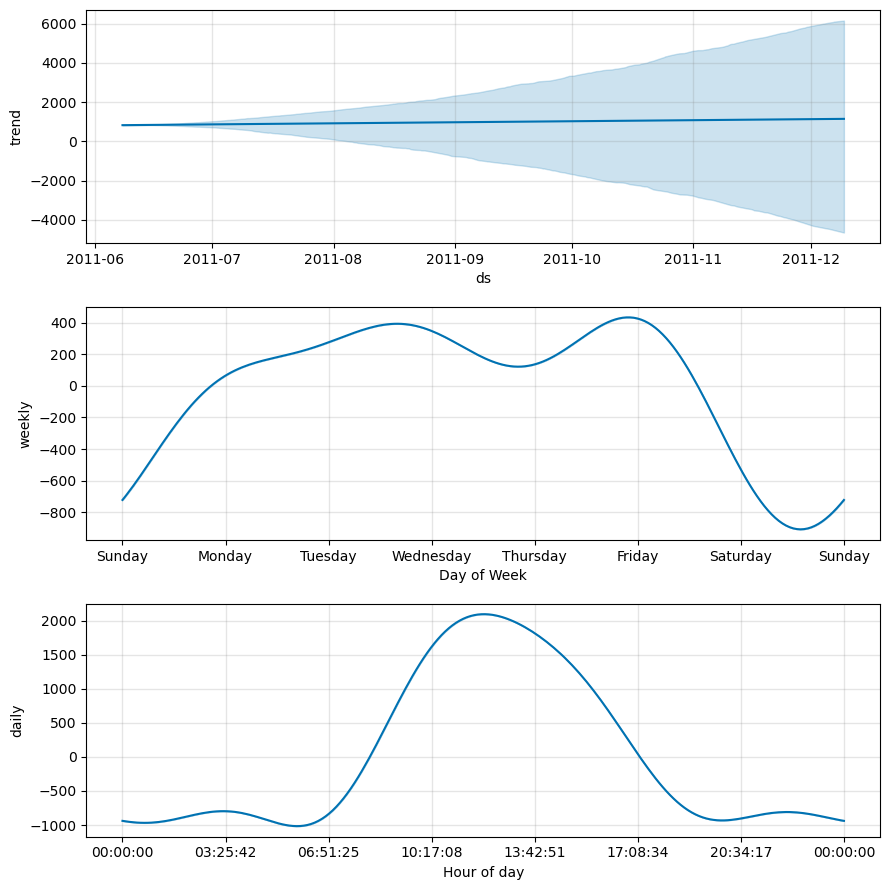

In [194]:
model.plot_components(fcst)

In [195]:
print(f"Our RMSE is: {np.sqrt(mean_squared_error(y_true=test.revenue, y_pred=fcst.yhat)):.3f}")
print(f"Our MAE is: {mean_absolute_error(y_true=test.revenue, y_pred=fcst.yhat):.3f}")
# print(f"Our MAPE is: {mean_absolute_percentage_error(test.revenue, fcst.yhat)}%")

Our RMSE is: 2362.054
Our MAE is: 1021.341
Our MAPE is: 1.5631727167914918e+18%


Quite awful.  Let's try again but with weekly data instead of hourly.

In [196]:
weeklydf = df[df.country == 'United Kingdom'][['invoicedate', 'revenue']].resample(rule='W', on='invoicedate').sum().reset_index()
weekdf = makeTimeFeatures(weeklydf)
weekdf['dayofweek'] = [x.strftime('%A') for x in weekdf.invoicedate]  # Replace the day numbers with day names.  Could change in function, but this is mostly for the plot
weekdf.head()

C:\Users\Zade\AppData\Local\Temp\ipykernel_6784\2333629205.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df[datecol].dt.weekofyear


,invoicedate,revenue,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,season
0,2009-12-06,242679.06,Sunday,12,4,2009,340,6,49,Fall
1,2009-12-13,222429.73,Sunday,12,4,2009,347,13,50,Fall
2,2009-12-20,226897.91,Sunday,12,4,2009,354,20,51,Fall
3,2009-12-27,38255.85,Sunday,12,4,2009,361,27,52,Fall
4,2010-01-03,0.00,Sunday,1,1,2010,3,3,53,Winter


15:45:16 - cmdstanpy - INFO - Chain [1] start processing


75.47% of our data is in the training with this cutoff date


15:45:16 - cmdstanpy - INFO - Chain [1] done processing


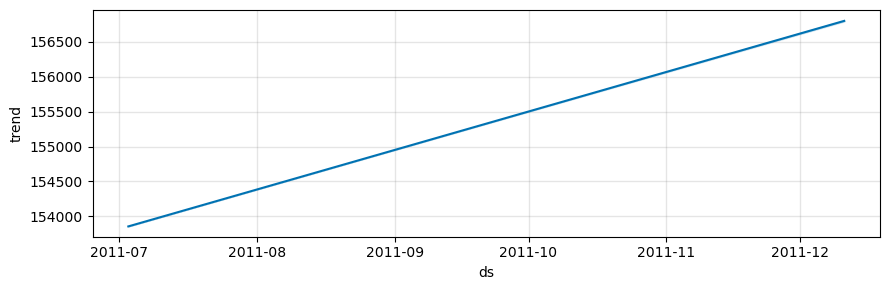

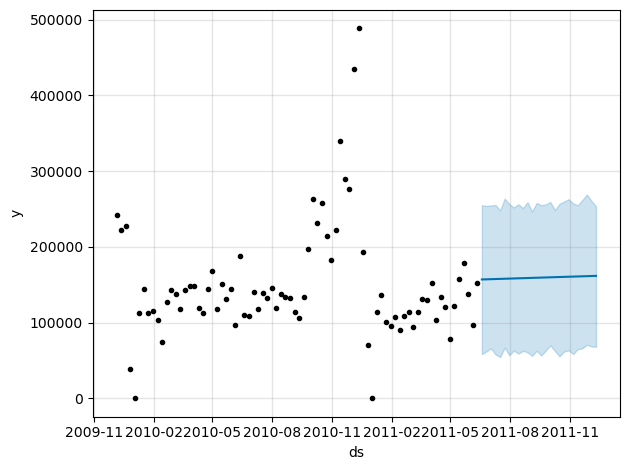

In [201]:
cutoffdate = '2011-06-15'  # Get a roughly 75-25 split in our data
train2 = weekdf.loc[weekdf.invoicedate <= cutoffdate].copy()
test2 = weekdf.loc[weekdf.invoicedate > cutoffdate].copy()
print(f"{len(train2)/len(weekdf)*100:.2f}% of our data is in the training with this cutoff date")
trainProph2 = train2.rename(columns={'invoicedate':'ds', 'revenue':'y'})
testProph2 = test2.rename(columns={'invoicedate':'ds', 'revenue':'y'})
model2 = Prophet()
model2.fit(trainProph2)
fcst2 = model2.predict(testProph2)
fig, ax = plt.subplots()
fig = model2.plot(fcst2, ax=ax);
plt.show();

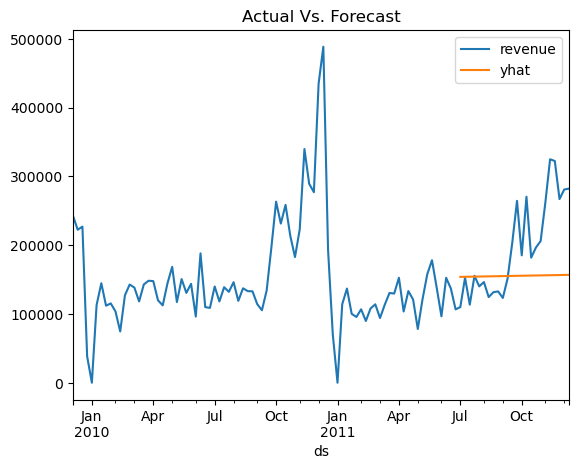

In [198]:
ax = (weekdf.plot(x='invoicedate', y='revenue', title='Actual Vs. Forecast'));
fcst2.plot(x='ds', y='yhat', ax=ax);
plt.show();

## 2: XGBoost

### 2.1: TimeSeriesSplit Modeling
Our average RMSE is: 2467.136 with a minimum RMSE of 944.574

In [348]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

In [209]:
tss = TimeSeriesSplit(n_splits=5, test_size=52, gap=24)

In [210]:
#Uncomment to view train/test splits by fold if needed

# fig, axes = plt.subplots(5,1, figsize=(10,10), sharex=True)
# fold=0
# for train_idx, test_idx in tss.split(nofulluk):
#     train = nofulluk.iloc[train_idx]
#     test = nofulluk.iloc[test_idx]
#     train.revenue.plot(ax=axes[fold], label='Training', title=f"Train/Test Split Fold {fold}");
#     test.revenue.plot(ax=axes[fold], label='Testing');
#     fold += 1
# plt.show();

In [211]:
timedf.head()

,revenue,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,season,lag1,lag10,lag100
invoicedate,,,,,,,,,,,,
2009-12-01 07:00:00,651.10,Tuesday,12,4,2009,335,1,49,Fall,NaN,NaN,NaN
2009-12-01 08:00:00,0.00,Tuesday,12,4,2009,335,1,49,Fall,NaN,NaN,NaN
2009-12-01 09:00:00,4597.93,Tuesday,12,4,2009,335,1,49,Fall,NaN,NaN,NaN
2009-12-01 10:00:00,4238.66,Tuesday,12,4,2009,335,1,49,Fall,NaN,NaN,NaN
2009-12-01 11:00:00,4598.41,Tuesday,12,4,2009,335,1,49,Fall,NaN,NaN,NaN


In [213]:
timedf = timedf.set_index('invoicedate').sort_index()
# timedf['lag1'] = timedf['revenue'].shift(freq='1D')
# timedf['lag10'] = timedf['revenue'].shift(freq='10D')
# timedf['lag100'] = timedf['revenue'].shift(freq='100D')
targets = timedf.revenue.to_dict()
timedf['lag1'] = (timedf.index - pd.Timedelta('1 days')).map(targets)
timedf['lag10'] = (timedf.index - pd.Timedelta('10 days')).map(targets)
timedf['lag100'] = (timedf.index - pd.Timedelta('100 days')).map(targets)

In [214]:
timedf.tail()

,revenue,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,season,lag1,lag10,lag100
invoicedate,,,,,,,,,,,,
2011-12-09 08:00:00,963.04,Friday,12,4,2011,343,9,49,Fall,482.28,1142.41,0.00
2011-12-09 09:00:00,3209.48,Friday,12,4,2011,343,9,49,Fall,16511.59,5032.14,3053.96
2011-12-09 10:00:00,16448.50,Friday,12,4,2011,343,9,49,Fall,5424.21,6130.17,2562.40
2011-12-09 11:00:00,1638.74,Friday,12,4,2011,343,9,49,Fall,7275.70,11905.01,856.20
2011-12-09 12:00:00,2757.40,Friday,12,4,2011,343,9,49,Fall,7810.56,6138.15,602.40


Dummie encode our categorical variables for XGBoost.  Normalization isn't needed as we're using decision trees.

In [229]:
seasondummies = pd.get_dummies(timedf.season, prefix='season')
dayofweekdummies = pd.get_dummies(timedf.dayofweek, prefix='dow')
dummiedf = pd.concat([timedf, seasondummies, dayofweekdummies], axis=1)
dummiedf.drop(columns=['season', 'dayofweek'], inplace=True)
dummiedf.head()

,revenue,month,quarter,year,dayofyear,dayofmonth,weekofyear,lag1,lag10,lag100,...,season_Spring,season_Summer,season_Fall,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
invoicedate,,,,,,,,,,,,,,,,,,,,,
2009-12-01 07:00:00,651.10,12,4,2009,335,1,49,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
2009-12-01 08:00:00,0.00,12,4,2009,335,1,49,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
2009-12-01 09:00:00,4597.93,12,4,2009,335,1,49,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
2009-12-01 10:00:00,4238.66,12,4,2009,335,1,49,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
2009-12-01 11:00:00,4598.41,12,4,2009,335,1,49,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0


In [230]:
fold = 0
preds = []
scores = []  # storing RMSE values
target = 'revenue'
MAPES = []
for train_idx, test_idx in tss.split(dummiedf):
    train = dummiedf.iloc[train_idx]
    test = dummiedf.iloc[test_idx]
    X_train = train.loc[:, train.columns != target]
    y_train = train[target]
    X_test = test.loc[:, test.columns != target]
    y_test = test[target]
    reg = xgb.XGBRegressor(booster='gbtree', early_stopping_rounds=50,
                           objective='reg:squarederror', max_depth=3)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    MAPES.append(MAPE)
    scores.append(score)

[0]	validation_0-rmse:2279.55334	validation_1-rmse:3222.01944
[99]	validation_0-rmse:1595.40601	validation_1-rmse:1851.15788
[0]	validation_0-rmse:2283.59680	validation_1-rmse:2994.61905
[56]	validation_0-rmse:1711.02321	validation_1-rmse:2342.62079
[0]	validation_0-rmse:2284.59619	validation_1-rmse:1179.40816
[53]	validation_0-rmse:1741.51691	validation_1-rmse:1514.94349
[0]	validation_0-rmse:2284.84407	validation_1-rmse:4818.35078
[63]	validation_0-rmse:1702.94238	validation_1-rmse:4242.84505
[0]	validation_0-rmse:2293.38771	validation_1-rmse:5148.72180
[60]	validation_0-rmse:1703.74841	validation_1-rmse:4422.66630


In [231]:
print(f"Our average RMSE is: {np.mean(scores):.3f} with a minimum RMSE of {np.min(scores):.3f}")
# print(f"Our average MAPE is {np.mean(MAPES):.3f} with a minimum MAPE of {np.min(MAPES):.3f} - though our XGBoost is scoring by RMSE")

Our average RMSE is: 2467.136 with a minimum RMSE of 944.574
Our average MAPE is 482074934270411968.000 with a minimum MAPE of 158616862343722528.000 - though our XGBoost is scoring by RMSE


### 2.2: HYPEROPT Modeling and Forecasting
Our best model's RMSE is 2257.459
We forecast out in to the future for one year, but since the trend is roughly linear, the plot is a roughly horizontal line with noise.

Here we will use HYPEROPT to do hyperparameter tuning on our XGBoost, but won't utilize tss.  Instead we'll have a set cutoffdate.  This is mostly because this will already take quite a long time to run with all of our tuning, and as such adding in more cross validation would make it wildly expensive.  

In [236]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [234]:
# print(cutoffdate)  
target = 'revenue'
train = dummiedf[dummiedf.index <= cutoffdate]
test = dummiedf[dummiedf.index > cutoffdate]
print(len(train)/len(dummiedf)) #roughly 76-24 split here
X_train = train.loc[:, train.columns != target]
y_train = train[target]
X_test = test.loc[:, test.columns != target]
y_test = test[target]



0.7595665424991535


In [242]:
space={'eta' : hp.uniform('eta', 0.01, 0.1),
       'gamma' : hp.quniform('gamma', 1, 9, 1),
       'max_depth' : hp.quniform('max_depth', 2, 5, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),  # % of columns to use in each tree
       'n_estimators' : 200,
       'seed' : 543,
       'early_stopping_rounds' : 10
       }

In [243]:
def objective(space):
    clf=xgb.XGBRegressor(n_estimators=space['n_estimators'], max_depth=int(space['max_depth']), gamma=int(space['gamma']),
                            eta=space['eta'], min_child_weight=int(space['min_child_weight']), colsample_bytree=(space['colsample_bytree']))

    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train, eval_set=evaluation)
    pred = clf.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, pred))
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=pred)
    print(f"Score: {score}")
    return {'loss': score, 'mape': mape, 'status': STATUS_OK, 'model': clf}


In [244]:
trials = Trials()
best_hparams = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = 50,
                    trials = trials)

[0]	validation_0-rmse:2391.27997	validation_1-rmse:2998.98526
[1]	validation_0-rmse:2375.91418	validation_1-rmse:2980.01027
[2]	validation_0-rmse:2349.11157	validation_1-rmse:2950.64417
[3]	validation_0-rmse:2336.71445	validation_1-rmse:2935.74674
[4]	validation_0-rmse:2300.47246	validation_1-rmse:2896.45882
[5]	validation_0-rmse:2286.99222	validation_1-rmse:2881.01227
[6]	validation_0-rmse:2275.21491	validation_1-rmse:2866.25697
[7]	validation_0-rmse:2264.29253	validation_1-rmse:2854.63689
[8]	validation_0-rmse:2242.83493	validation_1-rmse:2827.73365
[9]	validation_0-rmse:2224.54490	validation_1-rmse:2805.68279
[10]	validation_0-rmse:2218.02797	validation_1-rmse:2800.00485
[11]	validation_0-rmse:2211.40340	validation_1-rmse:2791.55205
[12]	validation_0-rmse:2205.83462	validation_1-rmse:2786.75072
[13]	validation_0-rmse:2200.64843	validation_1-rmse:2782.31626
[14]	validation_0-rmse:2195.69739	validation_1-rmse:2775.88301
[15]	validation_0-rmse:2190.77208	validation_1-rmse:2770.53011
[1

In [246]:
best_hparams

{'colsample_bytree': 0.4357299521674466,
 'eta': 0.03004247244619516,
 'gamma': 9.0,
 'max_depth': 4.0,
 'min_child_weight': 7.0}

In [248]:
print(f"RMSE: {trials.best_trial['result']['loss']:.3f}")

RMSE: 2257.459


See feature importance 

In [359]:
importantSorted = np.argsort(trials.best_trial['result']['model'].feature_importances_)[::-1]
for idx in importantSorted[:10]:
    print([train.columns[idx], trials.best_trial['result']['model'].feature_importances_[idx]])

['dow_Monday', 0.22774337]
['weekofyear', 0.18200679]
['lag1', 0.082816996]
['season_Summer', 0.077220835]
['lag10', 0.059872754]
['dow_Thursday', 0.05381255]
['dow_Friday', 0.049161803]
['dayofmonth', 0.039311096]
['year', 0.037640724]
['dow_Tuesday', 0.032862402]


Feature importance by gain

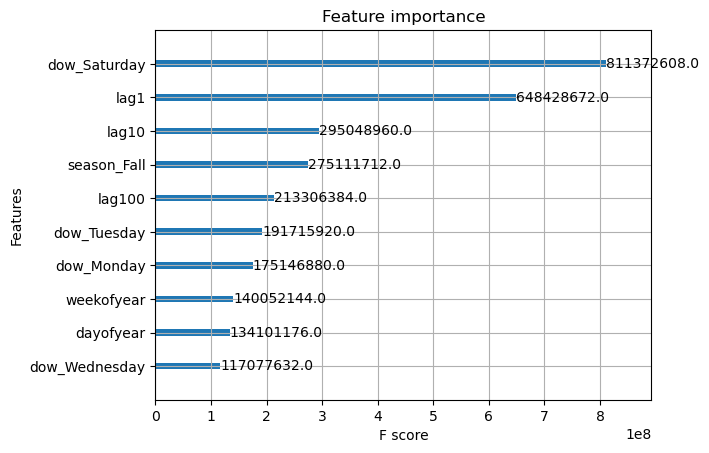

In [360]:
plot_importance(trials.best_trial['result']['model'], max_num_features=10, importance_type='gain')
plt.show();

Feature importance by weight

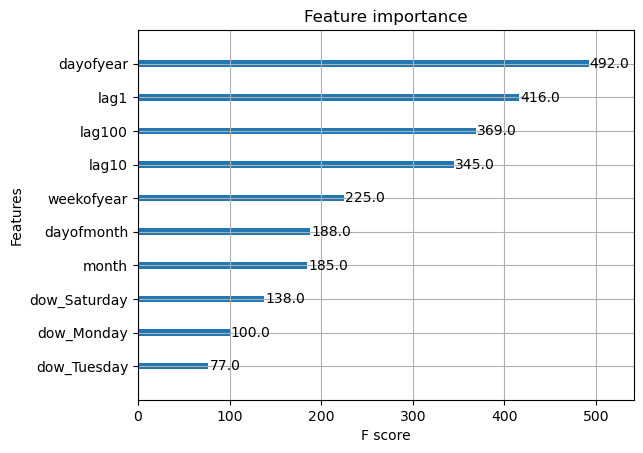

In [361]:
plot_importance(trials.best_trial['result']['model'], max_num_features=10, importance_type='weight')
plt.show();

We will now use our best model to forecast into the future

In [255]:
X_full = dummiedf.loc[:, dummiedf.columns != 'revenue']
y_full = dummiedf['revenue']
reg = trials.best_trial['result']['model']  # best model from hyperopt tuning above
reg.fit(X_full, y_full, eval_set=[(X_full, y_full)], verbose=100);

[0]	validation_0-rmse:2562.55973
[100]	validation_0-rmse:1878.92148
[199]	validation_0-rmse:1817.03700


In [257]:
dummiedf.index.max()

Timestamp('2011-12-09 12:00:00')

In [409]:
# Create hourly timestamps for a year out from our initial maximum date
future = pd.date_range('2011-12-09', '2012-12-01', freq='1h')  
futuredf = pd.DataFrame(index=future)
futuredf['isFuture'] = True
dummiedf['isFuture'] = False
dfWithFuture = pd.concat([dummiedf, futuredf])
dfWithFuture = makeTimeFeatures(dfWithFuture, useidx=True)

C:\Users\Zade\AppData\Local\Temp\ipykernel_6784\2333629205.py:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [410]:
# Drop the dummified columns as we'll be redoing it for the full dataframe in a moment
dfWithFuture.drop(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter'], axis=1, inplace=True)
dfWithFuture.drop(['dow_Friday', 'dow_Saturday', 'dow_Sunday', 'dow_Monday', 'dow_Tuesday', 
                   'dow_Wednesday', 'dow_Thursday'],axis=1, inplace=True)
# dfWithFuture.columns

In [411]:
# Add lag and dummie features
targets = dfWithFuture.revenue.to_dict()
dfWithFuture['lag1'] = (dfWithFuture.index - pd.Timedelta('1 days')).map(targets)
dfWithFuture['lag10'] = (dfWithFuture.index - pd.Timedelta('10 days')).map(targets)
dfWithFuture['lag100'] = (dfWithFuture.index - pd.Timedelta('100 days')).map(targets)
seasondummies = pd.get_dummies(dfWithFuture.season, prefix='season')
dayofweekdummies = pd.get_dummies(dfWithFuture.dayofweek, prefix='dow')
dfWithFuture = pd.concat([dfWithFuture, seasondummies, dayofweekdummies], axis=1)

In [424]:
# Keep column names consistent
dfWithFuture.rename(columns={"dow_0":"dow_Monday", "dow_1":"dow_Tuesday", "dow_2":"dow_Wednesday",
                             "dow_3":"dow_Thursday", "dow_4":"dow_Friday", "dow_5":"dow_Saturday",
                             "dow_6":"dow_Sunday"}, inplace=True)

In [425]:
dfWithFuture.drop(['dayofweek', 'season'], axis=1, inplace=True)  # Drop the categorical columns, leave dummies

In [439]:
futureOnly = dfWithFuture[dfWithFuture.isFuture == True].copy()
# get original columns as list to preserve order for prediction
originalCols = ['month', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 
                'lag1', 'lag10', 'lag100', 'season_Winter', 'season_Spring', 'season_Summer', 
                'season_Fall', 'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 
                'dow_Tuesday', 'dow_Wednesday'] 

In [442]:
futureOnly['revenue'] = reg.predict(futureOnly[originalCols])  # Predict on our future dates

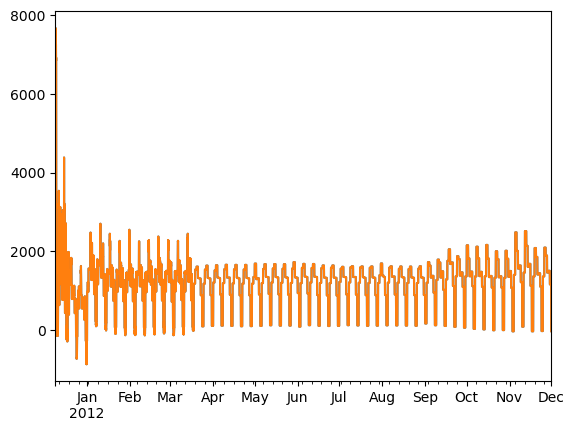

In [445]:
futureOnly.revenue.plot();
plt.show();

Again, since there is very little of a slope in our revenue, we see predictions that are roughly horizontal and linear with quite a bit of noise about the horizontal trend line.

## 3: Linear Regression
Obviously our data violates regression assumptions, but this is just to see how it compares as a baseline ('awful') model.

MSE: 4987067278.680

RMSE: 70619.171

R2: -0.059

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
# As we had before.  Remake so we don't need to run all - didn't save this elsewhere
weeklydf = df[df.country == 'United Kingdom'][['invoicedate', 'revenue']].resample(rule='W', on='invoicedate').sum().reset_index() 
weeklydf['daysFromStart'] = (weeklydf.invoicedate - weeklydf.invoicedate[0]).dt.days
# weeklydf
# roughly 74-26 split by invoicedate
train = weeklydf[weeklydf.invoicedate <= '2011-06-01']
test = weeklydf[weeklydf.invoicedate > '2011-06-01']


trainX = train.daysFromStart.values.reshape(-1,1)
trainy = train.revenue
testX = test.daysFromStart.values.reshape(-1,1)
testy = test.revenue

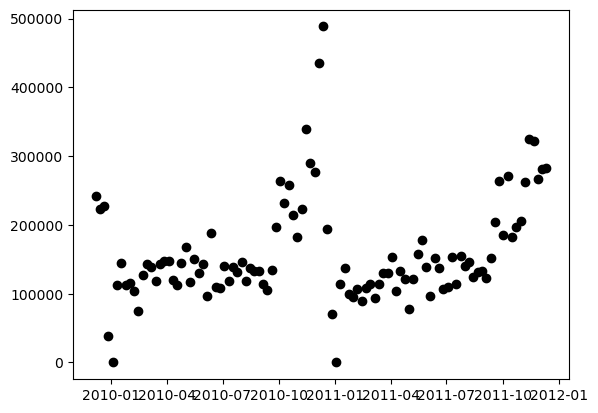

In [57]:
# Show our raw data
plt.scatter(weeklydf.invoicedate, weeklydf.revenue, c='black')
plt.show();

In [59]:
reg = LinearRegression().fit(trainX, trainy)
pred = reg.predict(testX)
print(f"MSE: {mean_squared_error(testy, pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(testy, pred)):.3f}")
print(f"R2: {r2_score(testy, pred):.3f}")

MSE: 4987067278.680
RMSE: 70619.171
R2: -0.059


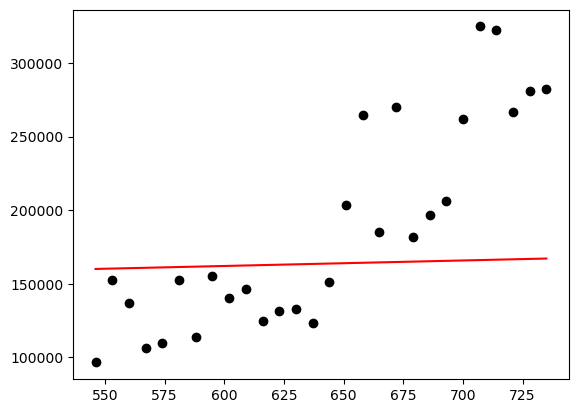

In [55]:
plt.scatter(testX, testy, c='black')
plt.plot(testX, pred, color='red')
plt.show();